In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.neighbors import KernelDensity 

import torch
import torch.nn as nn
from torch.optim import Adam

In [3]:
class GAN(nn.Module):
    def __init__(self, size_hidden, latent_size):
        super().__init__()

        self.hidden_size = size_hidden 
        self.latent_size = latent_size

        self.generator = nn.Sequential(
            nn.Linear(self.latent_size, self.hidden_size), 
            nn.ReLU(True),
            nn.Linear(self.hidden_size,self.hidden_size),
            nn.ReLU(True),
            nn.Linear(self.hidden_size,2)
        )

        self.discriminator = nn.Sequential(
            nn.Linear(2, self.hidden_size), 
            nn.ReLU(True),
            nn.Linear(self.hidden_size,self.hidden_size),
            nn.ReLU(True),
            nn.Linear(self.hidden_size,1),
            nn.Sigmoid()
        )
    
    def sample(self, n_samples, device):
        with torch.no_grad():
            return self.generator(torch.randn(n_samples,self.latent_size).to(device))

    def fit(self, x, max_iter, lr_d, lr_g):
        loss_d, loss_g = [], []
        criterion = nn.BCELoss() 

        optimizerD = Adam(self.discriminator.parameters(), lr=lr_d)
        optimizerG = Adam(self.generator.parameters(), lr=lr_g)

        # Establish convention for real and fake labels during training
        real_label = 1.
        fake_label = 0.
        fixed_noise = torch.randn(x.shape[0], self.latent_size, device=x.device)
        samples = []

        for it in range(max_iter):
            # (1) update D network: maximize log(D(x)) + log(1-D(G(z)))
            self.discriminator.zero_grad()

            # train with real batch
            label = torch.full((x.shape[0],1), real_label, dtype=torch.float, device=x.device)
            output = self.discriminator(x)
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()

            # train with fake batch
            noise = torch.randn(x.shape[0],self.latent_size,device=x.device)
            fake = self.generator(noise)
            label = label.fill_(fake_label)
            output = self.discriminator(fake.detach())
            errD_fake = criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            optimizerD.step()

            loss_d.append(errD.item())

            # (2) update G network: maximize log(D(G(z)))
            self.generator.zero_grad()
            label = label.fill_(real_label)
            output = self.discriminator(fake)
            errG = criterion(output,label)
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()

            loss_g.append(errG.item())

            x = shuffle(x)
            if it % 100 == 0:
                samples.append(self.generator(fixed_noise))

        return samples, loss_g, loss_d

torch.Size([2000, 2])


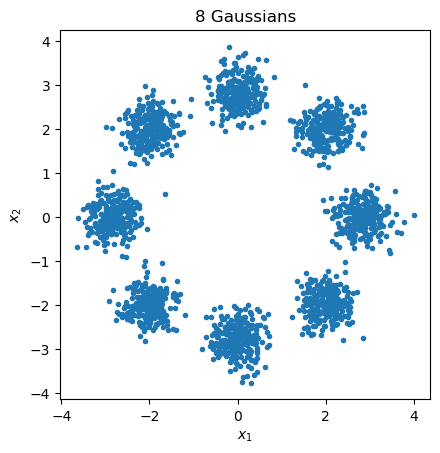

In [4]:
# generate data
n_samples = 2000
z = torch.randn(n_samples, 2)

sq = 1./np.sqrt(2)
fact = 4.*sq
mus = [fact*torch.Tensor([[1.],[0.]]), fact*torch.Tensor([[-1.],[0.]]), fact*torch.Tensor([[0.],[1.]]), fact*torch.Tensor([[0.],[-1.]]),\
    fact*torch.Tensor([[sq],[sq]]), fact*torch.Tensor([[-sq],[sq]]), fact*torch.Tensor([[sq],[-sq]]), fact*torch.Tensor([[-sq],[-sq]])]

sig = 0.1 * torch.Tensor([[1.,0.0],[0.0,1.]])
x_all = [mu + torch.linalg.cholesky(sig)@torch.randn(2,int(n_samples/8.)) for mu in mus]
x = torch.hstack(x_all).T
mus = torch.hstack(mus) # 2,8
print(x.shape)

fig, ax = plt.subplots(1,1)
ax.set_aspect('equal', 'box')
ax.scatter(x[:,0],x[:,1],marker='.'), plt.title('8 Gaussians')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()

In [5]:
# settings
max_iter = 20000
lr_d = 5.0E-4
lr_g = 5.0E-4
size_hidden = 128
latent_size = 2

In [6]:
gan = GAN(size_hidden=size_hidden,latent_size=latent_size)
samples_check, loss_g, loss_d = gan.fit(x,max_iter,lr_d, lr_g)


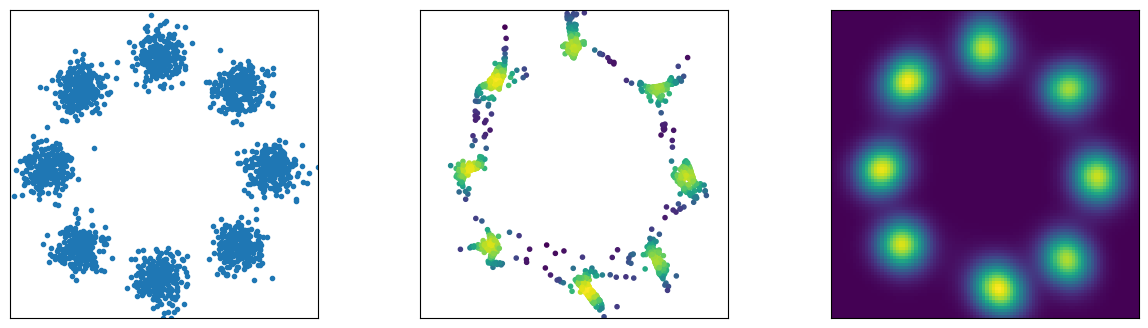

In [8]:
samples = gan.sample(n_samples,x.device)

# kde
samples = samples.detach().cpu()
kde = KernelDensity(bandwidth=.4).fit(samples)
xx, yy = np.meshgrid(np.linspace(x.min().item(),x.max().item(),100),np.linspace(x.min().item(),x.max().item(),100))
x_grid = np.stack((xx.ravel(), yy.ravel()),1)
density = np.exp(kde.score_samples(x_grid))

samples_kde = np.exp(kde.score_samples(samples))

fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(x[:,0].cpu(),x[:,1].cpu(),marker='.')
ax1.set_xlim([x.min().item(),x.max().item()]), ax1.set_ylim([x.min().item(),x.max().item()])
ax1.set_aspect('equal'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(1, 3, 2, sharex = ax1,sharey=ax1)
ax2.scatter(samples[:,0],samples[:,1],marker='.',c=samples_kde)
ax2.set_aspect('equal'), ax2.set_xticks([]), ax2.set_yticks([])
ax2.set_xlim([x.min().item(),x.max().item()]), ax2.set_ylim([x.min().item(),x.max().item()])
ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(density.reshape(100,100),origin='lower'), ax3.set_xticks([]), ax3.set_yticks([])
plt.savefig(os.getcwd() + '/out/gan.png',bbox_inches='tight')
plt.show()